In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import tensorflow as tf
import gym
import time
import matplotlib.pyplot as plt

In [3]:
env = gym.make('CartPole-v0')

c:\Users\Gediy\anaconda3\envs\APS1080\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [4]:
# building a NN  model
def build_model(state_size, action_size):
    model = Sequential()
    model.add(Dense(128, input_dim=state_size, name = "Layer1", activation='relu'))
    # model.add(Dense(34, name = "Layer2", activation='relu'))
    model.add(Dense(action_size, name = "Layer3", activation='softmax'))

    return model

p_inputSpace = env.observation_space.shape[0]        # observation space
p_outputSpace = env.action_space.n            # action space

model = build_model(p_inputSpace, p_outputSpace)
model.summary()

# f_ppError = keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

c:\Users\Gediy\anaconda3\envs\APS1080\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer1 (Dense)                  │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer3 (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898 (3.51 KB)

 Trainable params: 898 (3.51 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#test
def test():
    steps_to_solution = []

    for j in range(10):
        state = env.reset()
        state = state[0]

        for i in range(1,50000):
            
          pi = model.predict(state.reshape(1,env.observation_space.shape[0]), verbose= 0)  # soft-max in action preference
          action = np.random.choice(np.arange(env.action_space.n), p = pi[0])

          state, reward, done, info, _ = env.step(action)
          #print("step",i, "reward: ", reward," state: ", state," action=",action)

          if done:
              #print ("done")
              steps_to_solution.append(i)
              break

    # print(steps_to_solution)
    avg_step = np.mean(steps_to_solution)
    # print("Average steps to solution per 100 episodes: ",avg_step)

    # ipythondisplay.clear_output(wait=True)
    env.close()
    
    return avg_step

In [6]:
def train():
  perf_over_time = []

  gamma = 1   #discount factor

  start_timer = time.time() # starting the timer

  episodes = 500    # training episodes
  episode = 1       # episode counter

  while episode < episodes:
    state = env.reset()
    state = state[0]
    
    pi = model.predict(state.reshape(1,env.observation_space.shape[0]), verbose= 0)  # soft-max in action preference
    action = np.random.choice(np.arange(env.action_space.n), p = pi[0])

    # initializing a list to save the episode's trajectory
    episode_trajectory = [[0, state, action]] # starting reward (0) and state-action pair

      # generating an episodes using a an epsilon greedy policy
    while True:

      state, reward, done, info,_ = env.step(action)

      if done:
        episode_trajectory.append([reward, state, None])
        break

      
      pi = model.predict(state.reshape(1,env.observation_space.shape[0]), verbose= 0)  # soft-max in action preference
      action = np.random.choice(np.arange(env.action_space.n), p = pi[0]) #action selection based on the soft-max in action preference

      episode_trajectory.append([reward, state, action])


    for t in range(len(episode_trajectory)-1): # loop througn t= 0, 1 ... , T-1
      G = sum([(gamma**(k-t-1)) * episode_trajectory[k][0] for k in range(t+1,len(episode_trajectory))])

      s_t = episode_trajectory[t][1]
      a_t = episode_trajectory[t][2]

      with tf.GradientTape() as tape:
          prediction = model(s_t.reshape(1,env.observation_space.shape[0]),training=True)
          selected_action_prob = prediction[0][a_t]     # the probability of selecting action a_t at time step t due to the parametrized policy
          loss = tf.math.log(selected_action_prob)
          

      grads = tape.gradient(loss,model.trainable_weights) # obtaining the gradient 
      
      # Modify the gradients
      scaled_grads = [ -G * (gamma**t) * grad for grad in grads]
      optimizer.apply_gradients(zip(scaled_grads, model.trainable_weights))
      
      
    episode += 1
    if episode % 10 == 0:
        end_timer = time.time()
        timer = end_timer - start_timer
        elapsed_time_struct = time.gmtime(timer)
        formatted_time = time.strftime("%H:%M:%S", elapsed_time_struct)
        performance = test() # caluclate avg performance per 100 episodes
        print("Episode: ",episode, " time: ", formatted_time, " Performance: ", performance)
        perf_over_time.append([episode,performance])
        if performance >= 200:
            return perf_over_time

    if episode == episodes:
        print("done!")
        
  return perf_over_time


c:\Users\Gediy\anaconda3\envs\APS1080\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode:  10  time:  00:00:22  Performance:  53.6
Episode:  20  time:  00:01:11  Performance:  44.7
Episode:  30  time:  00:02:01  Performance:  99.8
Episode:  40  time:  00:03:32  Performance:  116.7
Episode:  50  time:  00:05:43  Performance:  113.5
Episode:  60  time:  00:07:37  Performance:  166.0
Episode:  70  time:  00:10:06  Performance:  157.1
Episode:  80  time:  00:12:31  Performance:  125.9
Episode:  90  time:  00:14:56  Performance:  110.1
Episode:  100  time:  00:16:58  Performance:  153.8
Episode:  110  time:  00:19:22  Performance:  148.6
Episode:  120  time:  00:21:52  Performance:  203.5


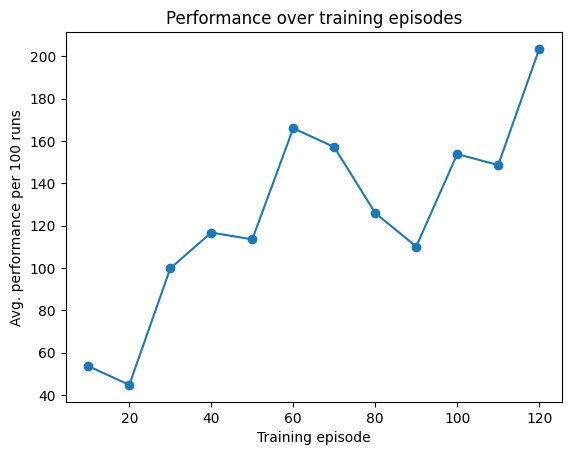

In [7]:
training_performance = train()

# saving the weights
model.save_weights('policy_gradient_model_v0_10k.weights.h5')

x,y = zip(*training_performance)

plt.plot(x,y, marker='o')
# Add labels and title
plt.xlabel('Training episode')
plt.ylabel('Avg. performance per 100 runs')
plt.title('Performance over training episodes')

# Display the plot
plt.show()

In [8]:
state = env.reset()
state = state[0]

for i in range(1,500):
    
    pi = model.predict(state.reshape(1,env.observation_space.shape[0]), verbose= 0)  # soft-max in action preference
    action = np.random.choice(np.arange(env.action_space.n), p = pi[0])

    state, reward, done, info, _ = env.step(action)
    print("step",i, "reward: ", reward," state: ", state," action=",action)

    if done:
        print ("done")
        break

step 1 reward:  1.0  state:  [-0.01201085 -0.16031738  0.04529056  0.27991563]  action= 0
step 2 reward:  1.0  state:  [-0.0152172  -0.35605514  0.05088888  0.58653206]  action= 0
step 3 reward:  1.0  state:  [-0.0223383  -0.5518515   0.06261951  0.8948013 ]  action= 0
step 4 reward:  1.0  state:  [-0.03337533 -0.35763204  0.08051554  0.6224412 ]  action= 1
step 5 reward:  1.0  state:  [-0.04052797 -0.5537805   0.09296437  0.9393567 ]  action= 0
step 6 reward:  1.0  state:  [-0.05160358 -0.36002636  0.1117515   0.6772727 ]  action= 1
step 7 reward:  1.0  state:  [-0.05880411 -0.16661988  0.12529695  0.42175913]  action= 1
step 8 reward:  1.0  state:  [-0.0621365   0.02652485  0.13373214  0.17105423]  action= 1
step 9 reward:  1.0  state:  [-0.06160601  0.21950445  0.13715322 -0.07663038]  action= 1
step 10 reward:  1.0  state:  [-0.05721592  0.02271006  0.13562061  0.2559859 ]  action= 0
step 11 reward:  1.0  state:  [-0.05676172  0.21566132  0.14074033  0.00896696]  action= 1
step 12 